# Example 01: Sparsity and Inverse Problems with CDT

This example illustrates that reconstructing a signal from DCT coefficients of CDT (of that signal) gives better reconstruction than using DCT coefficients of the signal itself.

Import necessary python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import radon
from scipy.fftpack import dct, idct

In [2]:
from pytranskit.optrans.continuous.cdt import CDT

Following function reconstruct the signal from largest 'Nmax_coeff' number of DCT coefficients. 

In [3]:
def dct_recons(I1, Nmax_coeff):
    # calculate the DCT coefficients
    I_dct = dct(I1, norm='ortho', axis=0)

    # take largets 'Nmax_coeff' coefficients
    I_dct_ = I_dct.copy()    
    lowVal = np.sort(np.abs(I_dct_))[::-1][Nmax_coeff-1]
    I_dct_[np.abs(I_dct_)<lowVal] = 0

    # reconstruct the signal
    I_recon = idct(I_dct_, norm='ortho', axis=0)
    
    return I_recon

Following function reconstruct the signal from the largest 'Nmax_coeff' numbers of DCT coefficients of CDT.

In [4]:
def cdt_recons(x0, I0, x, I1_hat, Nmax_coeff):
    # calculate DCT coefficients of CDT of the signal
    I1_hat_dct = dct(I1_hat, norm='ortho', axis=0)

    # take largets 'Nmax_coeff' coefficients
    I1_hat_dct_ = I1_hat_dct.copy()    
    lowVal = np.sort(np.abs(I1_hat_dct_))[::-1][Nmax_coeff-1]
    I1_hat_dct_[np.abs(I1_hat_dct_)<lowVal] = 0
    
    # reconstruct the CDT using inverse DCT
    I1_hat_recon = idct(I1_hat_dct_, norm='ortho', axis=0)
    I1_hat_recon[0] = 0; I1_hat_recon[len(I1_hat_recon)-1] = 0  # recover the two edges of CDT
    f1_hat_recon = x0 + (I1_hat_recon/np.sqrt(I0))

    # reconstruct the signal using inverse CDT
    I1_recon, f1_recon = cdt.inverse(f1_hat_recon, I0, x)
    
    return I1_hat, I1_hat_recon, f1_hat_recon, I1_recon

Read the image and apply Radon transform

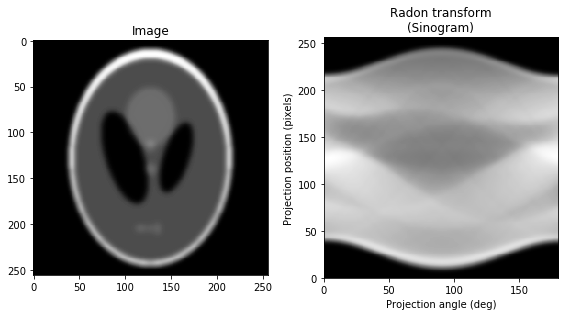

In [5]:
image = imread('images/phantom.png')
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Image")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
fig.tight_layout()
plt.show()

In [6]:
I1=sinogram[:, 0] # take one projection

N=len(I1)
epsilon = 1e-7
x=np.arange(N)
x0 = x
I0= np.ones(N)

I0 = abs(I0) + epsilon
I0 = N*I0/I0.sum()
I1 = abs(I1) + epsilon
I1 = N*I1/I1.sum()

Calculate CDT of the the projection $I_1$

In [7]:
cdt = CDT()

# Compute the forward transform
I1_hat, f1_hat, xtilde = cdt.forward(x0, I0, x, I1, rm_edge=False)
I1_hat[len(I1_hat)-1] = I1_hat[len(I1_hat)-2]+epsilon;

In [8]:
#mth_max = len(I1)
nth_max = 5  # select the number of largest DCT coefficients to use

# reconstruct from DCT coefficients of the projection
I_recon = dct_recons(I1, nth_max)

# reconstruct from DCT coefficients of CDT of the projection
I1_hat, I1_hat_recon, f1_hat_recon, I1_recon = cdt_recons(x0, I0, x, I1_hat, nth_max)

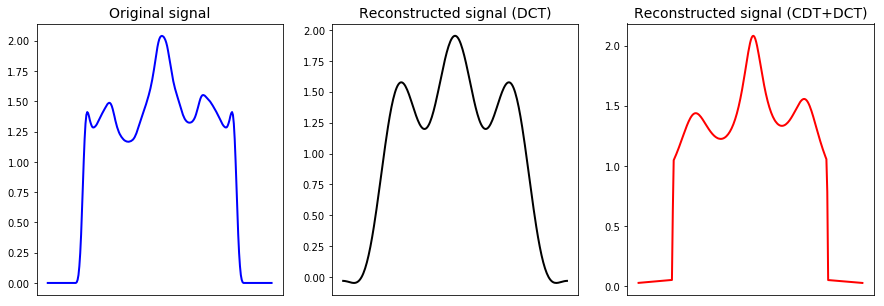

In [9]:
fontSize=14
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15,5))
ax[0].plot(x, I1, 'b-',linewidth=2)
ax[0].set_title('Original signal',fontsize=fontSize)
ax[0].set_xticks([])

ax[1].plot(xtilde, I_recon, 'k-',linewidth=2)
ax[1].set_title('Reconstructed signal (DCT)',fontsize=fontSize)
ax[1].set_xticks([])

ax[2].plot(xtilde, I1_recon, 'r-',linewidth=2)
ax[2].set_title('Reconstructed signal (CDT+DCT)',fontsize=fontSize)
ax[2].set_xticks([])

plt.show()

Calculate MSE and plot reconstructed signals

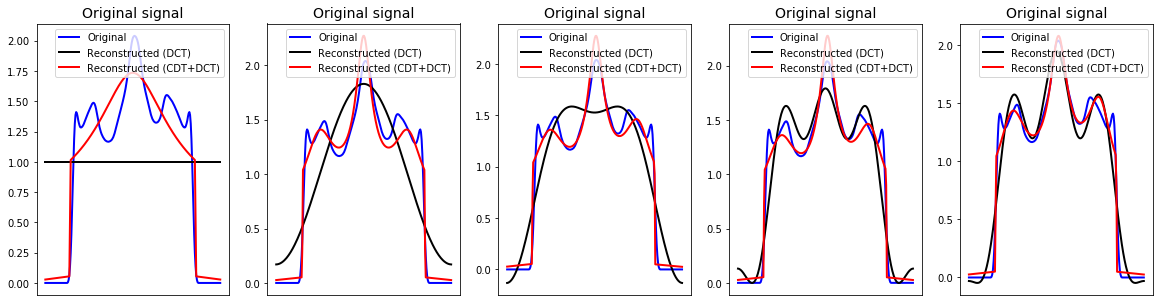

In [10]:
MSE_dct = []
MSE_cdt = []
Nmax_coeff = 5
fig, ax = plt.subplots(1, Nmax_coeff, sharex=False, sharey=False, figsize=(Nmax_coeff*4,5))
for N in range(1, Nmax_coeff+1):
    I_recon = dct_recons(I1, N)
    
    I1_hat, I1_recon, f1_hat_recon, I1_recon = cdt_recons(x0, I0, x, I1_hat, N)
    MSE_dct.append(np.mean((I1-I_recon)**2))
    MSE_cdt.append(np.mean((I1-I1_recon)**2))

    
    ax[N-1].plot(x, I1, 'b-',linewidth=2)
    ax[N-1].plot(xtilde, I_recon, 'k-',linewidth=2)
    ax[N-1].plot(xtilde, I1_recon, 'r-',linewidth=2)
    
    ax[N-1].set_title('Original signal',fontsize=fontSize)
    ax[N-1].legend(['Original', 'Reconstructed (DCT)', 'Reconstructed (CDT+DCT)'])
    ax[N-1].set_xticks([])

plt.show()

Plot MSE curves

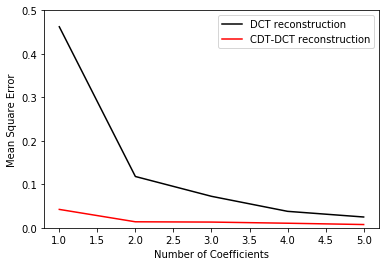

In [11]:
plt.Figure(figsize=(4, 3), dpi=200)
plt.plot(range(1, 6), MSE_dct, label='DCT reconstruction', color='black')
plt.plot(range(1, 6), MSE_cdt, label='CDT-DCT reconstruction', color='red')
plt.ylim([0, 0.5])
plt.ylabel('Mean Square Error')
plt.xlabel('Number of Coefficients')
plt.legend()
#plt.savefig('mse.png', dpi=200)
plt.show()